# Descripción del sistema dinámicio

1.  Seleccionar un sistema no-lineal mınimo de segundo orden: Motor de Induccion o DC, dos
tanques de liquido en serie, movimiento de un satelite, etc

### Resorte cubico

![title](resorte.png)

Ecuacion de un resorte cubico normalmente usados en carros

\begin{equation}m \ddot{x}=-k_{1} x-k_{2} x^{3}+f_{0}\end{equation}
$(\text { set } m=1)$
\begin{equation}\ddot{y}=-k_{1} y-k_{2} y^{3}+f_{0}\end{equation}

#### Carga de librerias

In [1]:
import numpy as np
from scipy import signal
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline

2. Linealizar sobre su punto de estabilidad o en un punto de operacion especifico

\begin{equation}\begin{aligned}
A=\left[\begin{array}{cc}
\frac{\partial f_{1}}{\partial x_{1}} & \frac{\partial f_{1}}{\partial x_{2}} \\
\frac{\partial f_{2}}{\partial x_{1}} & \frac{\partial f_{2}}{\partial x_{2}}
\end{array}\right]_{0} &=\left[\begin{array}{cc}
0 & 1 \\
-k_{1}-3 k_{2}(y)^{2} & 0
\end{array}\right]_{0} \\
&=\left[\begin{array}{cc}
0 & 1 \\
-k_{1}-3 k_{2}\left(y_{e}\right)^{2} & 0
\end{array}\right]
\end{aligned}\end{equation}

Se deriva F0 con respecto a x y se desaparece de la matriz de estados

Para los puntos de operacion

\begin{equation}y_{e}=0, \dot{y}_{e}=0\end{equation}

\begin{equation}A_{0}=\left[\begin{array}{cc}
0 & 1 \\
-k_{1} & 0
\end{array}\right]\end{equation}

#### Espacio de estados

In [2]:
k1 = 5
k2 = -2
A = [[0.0, 1.0],[-k1, 0.0]]
B = [[0.0],[1.0]]
C = [1.0,0.0]
D = 0.0
sys0 = signal.StateSpace(A,B,C,D)
t0,y0 = signal.step(sys0)

#### Integracion de ODE

In [3]:
# Integrador de ODE 
def model(x,t):
    y = x[0]
    dydt = x[1]
    dy2dt2 = -k1*y-k2*pow(y,3)+1
    return [dydt,dy2dt2]
t1 = np.linspace(0,7,1000)
x1 = odeint(model,[0, 0],t1)
y1 = x1[:,0]

3. Comparar las respuestas al escalon del sistema no-lineal y el linealizado

#### Comparacion de todos los modelos

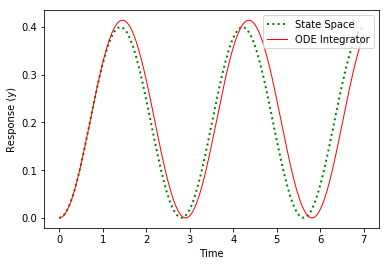

In [4]:
plt.figure(1)
plt.plot(t0,y0,'g:',linewidth=2,label='State Space')
plt.plot(t1,y1,'r-',linewidth=1,label='ODE Integrator')
plt.xlabel('Time')
plt.ylabel('Response (y)')
plt.legend(loc='upper right')
plt.show()

4. Determinar los polos del sistema

In [5]:
print(np.linalg.eig(A)[0])

[0.+2.23606798j 0.-2.23606798j]


 5. Discretizar el sistema lineal de tal forma que sus polos en z sean estables

#### Graficas de las respuestas al escalon para cada sistema discreto

In [6]:
dt0 = 0.1
dt1 = 0.5
sysd0 = sys0.to_discrete(dt0)
sysd1 = sys0.to_discrete(dt1)
t = np.linspace(0,4,100)
t0,y0 = signal.step(sys0, T=t)
td0,yd0 = signal.dstep(sysd0, t=t)
td1, yd1 = signal.dstep(sysd1, t=t)

los polos en z son sean estables

In [25]:
print (sysd0.to_zpk().poles[0], sysd0.to_zpk().poles[1])

(0.9751039932104794+0.22174806070172867j) (0.9751039932104794-0.22174806070172867j)


Los polos son menor que uno entonces son estables

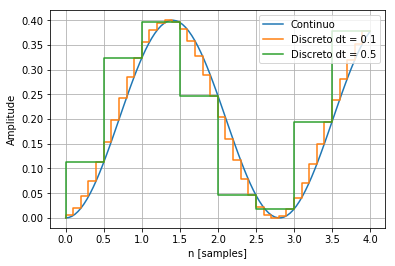

In [8]:
plt.figure(1)
plt.plot(t0, y0, label="Continuo")
plt.step(td0,  np.squeeze(yd0), label="Discreto dt = 0.1")
plt.step(td1,  np.squeeze(yd1), label="Discreto dt = 0.5")
plt.grid()
plt.xlabel('n [samples]')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.show()

# Mınimos cuadrados para estimacion de parametros:

1. Para el sistema discreto y linealizado encontrado en la seccion anterior, generar datos de yk y uk. Se puede usar una entrada de tipo impulso, escalon o escalones de diferentes amplitudes

In [9]:
y = np.squeeze(yd0)

2. Estimar para diferentes ordenes los parametros del sistema. Comparar los valores obtenidos
con el orden verdadero del sistema.

In [10]:
order = 2

In [11]:
T=[]
for i in range(0, order):
    T.append(y[order-1-i:len(y)-i-1]) 
T.append(np.ones(len(y)-order))
T=np.array(T).T
T.shape

(39, 3)

In [12]:
T_pinv = np.linalg.pinv(T)

In [13]:
theta = T_pinv@np.array([y[order:len(y)]]).T

In [14]:
y_result = T@theta

In [15]:
theta

array([[ 1.95020799],
       [-1.        ],
       [ 0.0099584 ]])

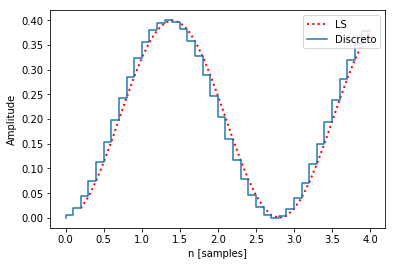

In [16]:
plt.plot(td0[order:len(td0)],y_result, 'r:',linewidth=2,label='LS')
plt.step(td0,  np.squeeze(yd0), label='Discreto')
plt.legend(loc='upper right')
plt.xlabel('n [samples]')
plt.ylabel('Amplitude')
plt.show()

# Filtro de Kalman para estimacion de parametros

1. Para el sistema discreto y linealizado encontrado en la seccion 1.3.1, generar datos de yk y uk. Se puede usar una entrada de tipo impulso, escalon o escalones de diferentes amplitudes.

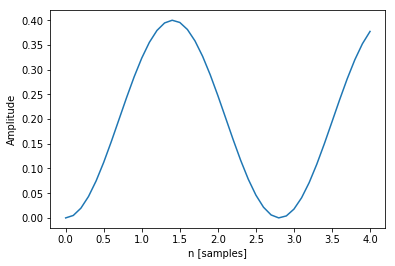

In [17]:
y = np.squeeze(yd0)
t = td0
N=len(t)
plt.plot(t, y)
plt.xlabel('n [samples]')
plt.ylabel('Amplitude')
plt.show()

In [18]:
order = 2
H=[]
for i in range(0, order):
    H.append(y[order-1-i:len(y)-i-1]) 
H.append(np.ones(len(y)-order))
H = np.array(H).T
H.shape

(39, 3)

#### Kalman Filter

 2. Estimar los parametros del sistema usando el filtro de Kalman visto en clase

In [19]:
if order+1==2:
    A = np.array([[1, 0], [0 , 1]])
    B = np.array([0, 0])
if order+1==3:
    A = np.array([[1, 0, 0], [0 , 1,0], [0 ,0, 1]])
    B = np.array([0, 0, 0])
if order+1==4:
    A = np.array([[1, 0, 0, 0], [0 , 1,0, 0], [0 ,0, 1, 0], [0 ,0, 0, 1]])
    B = np.array([1, 1, 1, 1])

In [20]:
mk = np.zeros((order+1,len(H)))
pk = 1e9
mk[:,0] = np.zeros(order+1)
R = 0.5
Q = 1.0
y_result=[]
for i in range(0,len(H)-1):
    mk1 = np.dot(A,mk[:,i])+np.dot(B,1)
    pk1 = np.dot(A,np.dot(pk,A.T))+Q
    Sk = np.dot(H[i], np.dot(pk1,H[i].T))+R
    Kk = np.dot(pk1,H[i].T)/(Sk)
    mk[:,i+1] = mk1 +np.dot(Kk,(y[i]-np.dot(H[i],mk1)))
    pk = pk1-np.dot(np.dot(Kk,(H[i])), pk1)
    y_result.append(np.dot(H[i], mk[:,i+1] ))

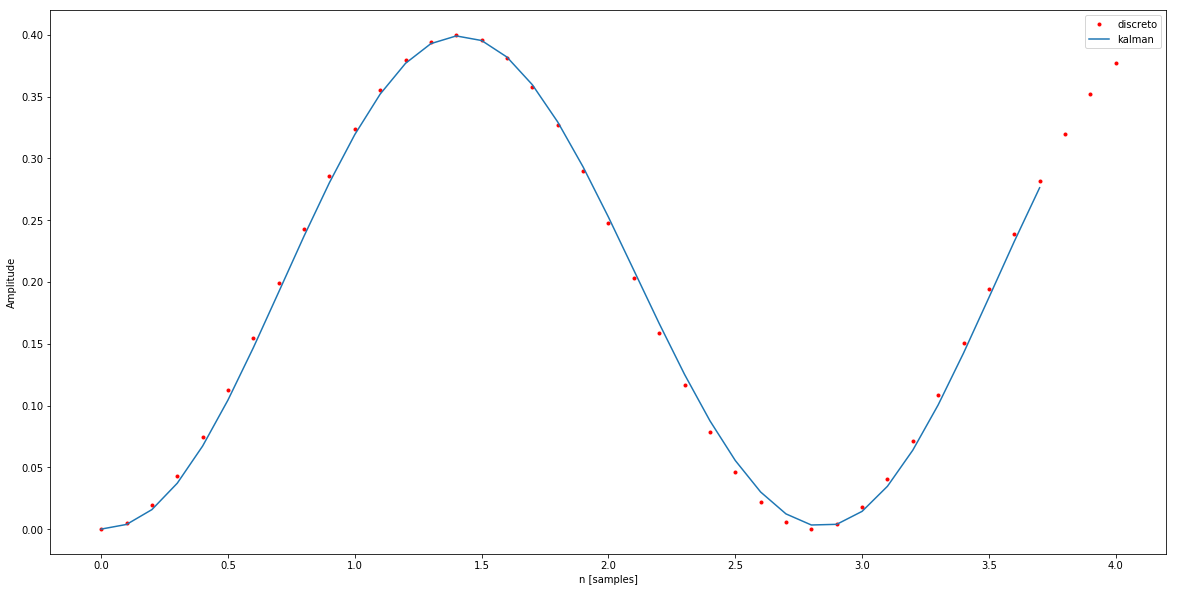

In [21]:
fig = plt.figure(figsize=(20,10))
plt.plot(t, y,'r.', label='discreto')
plt.plot(t[0:len(H)-1],y_result, label="kalman")
#plt.plot(t[0:len(H)],H@mk1 , label="kalman")
plt.xlabel('n [samples]')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.show()

[0.17095005 0.17089276 0.17351306]


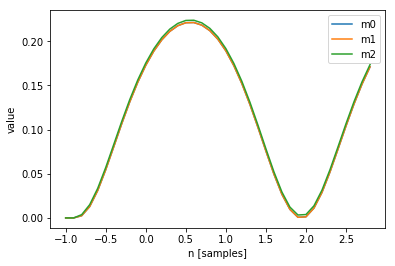

In [22]:
print(mk[:,-1])  
plt.figure()
for i in range(0,order+1):
    plt.plot(t[0:len(H)]-1,mk[i,:], label="m"+str(i))
plt.xlabel('n [samples]')
plt.ylabel('value')
plt.legend()
plt.show()

# TEST KALMAN FILTER

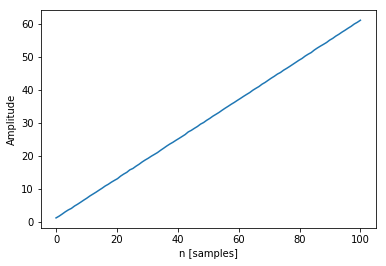

In [23]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

theta_1 = 1.0
theta_2 = 0.6
sigma2 = 0.05**2
N = 100
t = np.linspace(0.0,N,N)
y_true = theta_1 + theta_2*t
y = y_true + np.sqrt(sigma2)*np.random.randn(N)
plt.plot(t, y)
plt.xlabel('n [samples]')
plt.ylabel('Amplitude')
plt.show()

In [24]:
order = 1
H = np.zeros((N,1,order+1))

for i in range(0,N):
    temp = []
    for j in reversed(range(0,order+1)):
        temp.append(t[i]**j)
    H[i] = np.array(temp).T
H.shape

(100, 1, 2)